# Undistorting

Number of valid right calibration images: 76
Number of valid left calibration images: 76
Saved undistorted image to undistorted_rs\undistorted_right_right-0000.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0001.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0002.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0003.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0004.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0005.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0006.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0007.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0008.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0009.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0010.png
Saved undistorted image to undistorted_rs\undistorted_right_right-0011.png
Saved undis

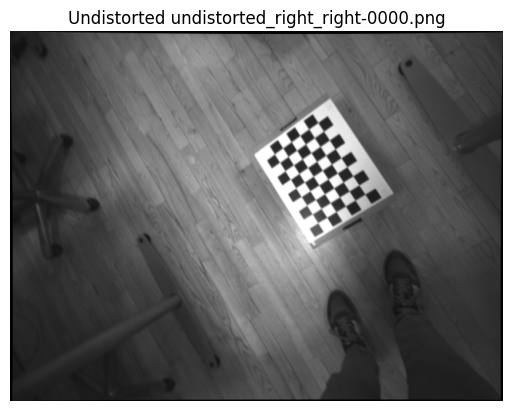

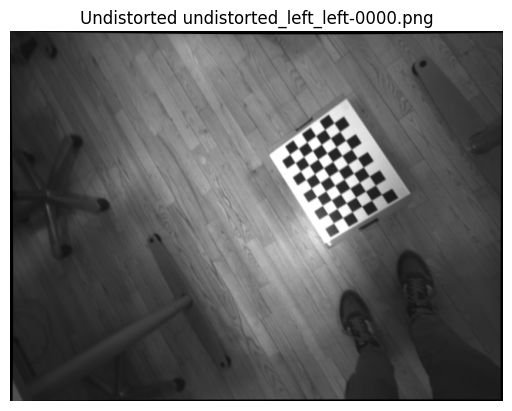

Processing completed successfully.


In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Number of corners in the chessboard pattern
nb_vertical = 9
nb_horizontal = 6

# Prepare object points (chessboard corners in 3D space)
objp = np.zeros((nb_horizontal * nb_vertical, 3), np.float32)
objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

# Create output directory for undistorted images
output_dir = 'undistorted_rs'
os.makedirs(output_dir, exist_ok=True)

# Collect both right and left images
right_images = glob.glob('rs/right-*.png')
left_images = glob.glob('rs/left-*.png')

# Ensure images exist for both types
assert right_images and left_images, "No images found in the specified directory."

# Function to process and store calibration data
def process_images(images):
    objpoints = []  # 3D points in real-world space
    imgpoints = []  # 2D points in the image plane.
    gray_example = None
    for fname in images:
        img = cv2.imread(fname)
        if img is None:
            print(f"Failed to load image {fname}")
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Keep the first grayscale image for calibration
        if gray_example is None:
            gray_example = gray

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal), None)

        # If found, add object points and image points (after refining them)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners (optional)
            # img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
            # cv2.imshow('Chessboard corners', img)
            # cv2.waitKey(500)
        else:
            print(f"Chessboard corners not found in image {fname}")

    # cv2.destroyAllWindows()
    return objpoints, imgpoints, gray_example

# Process the right images for calibration
objpoints_right, imgpoints_right, gray_example_right = process_images(right_images)
print(f"Number of valid right calibration images: {len(objpoints_right)}")

# Calibration for right camera
ret_right, mtx_right, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(
    objpoints_right, imgpoints_right, gray_example_right.shape[::-1], None, None
)

if not ret_right:
    print("Right camera calibration failed.")
    exit()

# Save calibration data for right camera
np.save('mtx_right.npy', mtx_right)
np.save('dist_right.npy', dist_right)

# Process the left images for calibration
objpoints_left, imgpoints_left, gray_example_left = process_images(left_images)
print(f"Number of valid left calibration images: {len(objpoints_left)}")

# Calibration for left camera
ret_left, mtx_left, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(
    objpoints_left, imgpoints_left, gray_example_left.shape[::-1], None, None
)

if not ret_left:
    print("Left camera calibration failed.")
    exit()

# Save calibration data for left camera
np.save('mtx_left.npy', mtx_left)
np.save('dist_left.npy', dist_left)

# Function to undistort and save images
def undistort_and_save(img_paths, prefix, mtx, dist):
    saved_files = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image {img_path}")
            continue
        h, w = img.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

        # Undistort the image
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
        
        # Save the undistorted image
        base_name = os.path.basename(img_path)
        save_path = os.path.join(output_dir, f"{prefix}_{base_name}")
        cv2.imwrite(save_path, dst)
        print(f"Saved undistorted image to {save_path}")
        saved_files.append(save_path)
    
    return saved_files

# Undistort and save right images using right camera parameters
saved_right_images = undistort_and_save(right_images, "undistorted_right", mtx_right, dist_right)

# Undistort and save left images using left camera parameters
saved_left_images = undistort_and_save(left_images, "undistorted_left", mtx_left, dist_left)

# Load and show the first undistorted image from the saved folder
def display_first_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image {image_path}")
        return
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f'Undistorted {os.path.basename(image_path)}')
    plt.axis('off')
    plt.show()

# Display the first saved undistorted image
if saved_right_images:
    display_first_image(saved_right_images[0])  # First right image

if saved_left_images:
    display_first_image(saved_left_images[0])   # First left image

print("Processing completed successfully.")


In [ ]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Number of corners in the chessboard pattern
nb_vertical = 9
nb_horizontal = 6

# Prepare object points (chessboard corners in 3D space)
objp = np.zeros((nb_horizontal * nb_vertical, 3), np.float32)
objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

# Create output directory for undistorted images
output_dir = 'undistorted_mynteye'
os.makedirs(output_dir, exist_ok=True)

# Collect both right and left images
right_images = glob.glob('mynteye/right-*.png')
left_images = glob.glob('mynteye/left-*.png')

# Ensure images exist for both types
assert right_images and left_images, "No images found in the specified directory."

# Function to process and store calibration data
def process_images(images):
    objpoints = []  # 3D points in real-world space
    imgpoints = []  # 2D points in the image plane.
    gray_example = None
    for fname in images:
        img = cv2.imread(fname)
        if img is None:
            print(f"Failed to load image {fname}")
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Keep the first grayscale image for calibration
        if gray_example is None:
            gray_example = gray

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal), None)

        # If found, add object points and image points (after refining them)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners (optional)
            # img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
            # cv2.imshow('Chessboard corners', img)
            # cv2.waitKey(500)
        else:
            print(f"Chessboard corners not found in image {fname}")

    # cv2.destroyAllWindows()
    return objpoints, imgpoints, gray_example

# Process the right images for calibration
objpoints_right, imgpoints_right, gray_example_right = process_images(right_images)
print(f"Number of valid right calibration images: {len(objpoints_right)}")

# Calibration for right camera
ret_right, mtx_right, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(
    objpoints_right, imgpoints_right, gray_example_right.shape[::-1], None, None
)

if not ret_right:
    print("Right camera calibration failed.")
    exit()

# Process the left images for calibration
objpoints_left, imgpoints_left, gray_example_left = process_images(left_images)
print(f"Number of valid left calibration images: {len(objpoints_left)}")

# Calibration for left camera
ret_left, mtx_left, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(
    objpoints_left, imgpoints_left, gray_example_left.shape[::-1], None, None
)

if not ret_left:
    print("Left camera calibration failed.")
    exit()

def undistort_and_save(img_paths, prefix, mtx, dist):
    saved_files = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image {img_path}")
            continue
        h, w = img.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(
            mtx, dist, (w, h), 1, (w, h)
        )

        # Undistort the image
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

        # Crop the image using the ROI
        x, y, w, h = roi
        dst = dst[y:y+h, x:x+w]

        # Save the undistorted and cropped image
        base_name = os.path.basename(img_path)
        save_path = os.path.join(output_dir, f"{prefix}_{base_name}")
        cv2.imwrite(save_path, dst)
        print(f"Saved undistorted and cropped image to {save_path}")
        saved_files.append(save_path)
    
    return saved_files


# Undistort and save right images using right camera parameters
saved_right_images = undistort_and_save(right_images, "undistorted_right", mtx_right, dist_right)

# Undistort and save left images using left camera parameters
saved_left_images = undistort_and_save(left_images, "undistorted_left", mtx_left, dist_left)

# Load and show the first undistorted image from the saved folder
def display_first_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image {image_path}")
        return
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f'Undistorted {os.path.basename(image_path)}')
    plt.axis('off')
    plt.show()

# Display the first saved undistorted image
if saved_right_images:
    display_first_image(saved_right_images[0])  # First right image

if saved_left_images:
    display_first_image(saved_left_images[0])   # First left image

print("Processing completed successfully.")

Number of valid right calibration images: 50


# Rectification

In [12]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# Paths to undistorted images
undistorted_left_images = sorted(glob.glob('undistorted_rs/undistorted_left_*.png'))
undistorted_right_images = sorted(glob.glob('undistorted_rs/undistorted_right_*.png'))

# Ensure the number of left and right images is the same
assert len(undistorted_left_images) == len(undistorted_right_images), "Number of left and right images must be equal."

# Create directories if they do not exist
os.makedirs('rectified/left', exist_ok=True)
os.makedirs('rectified/right', exist_ok=True)
os.makedirs('rectified/composite', exist_ok=True)

# Function to draw epilines on images
def draw_epilines(img1, img2, lines, pts1, pts2):
    ''' Draws epilines on the images.
        img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines
    '''
    r, c = img1.shape[:2]
    img1_color = img1.copy()
    img2_color = img2.copy()
    for r_line, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r_line[2] / r_line[1]])
        x1, y1 = map(int, [c, -(r_line[2] + r_line[0] * c) / r_line[1]])
        img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 1)
        img1_color = cv2.circle(img1_color, tuple(np.int32(pt1)), 5, color, -1)
        img2_color = cv2.circle(img2_color, tuple(np.int32(pt2)), 5, color, -1)
    return img1_color, img2_color

# Loop through all image pairs and process them
for idx, (fname_left, fname_right) in enumerate(zip(undistorted_left_images, undistorted_right_images)):
    img_left_color = cv2.imread(fname_left)
    img_right_color = cv2.imread(fname_right)
    if img_left_color is None or img_right_color is None:
        print(f"Failed to load images {fname_left} or {fname_right}")
        continue

    img_left_gray = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2GRAY)
    img_right_gray = cv2.cvtColor(img_right_color, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    kp_left, des_left = sift.detectAndCompute(img_left_gray, None)
    kp_right, des_right = sift.detectAndCompute(img_right_gray, None)

    # Check if descriptors are found
    if des_left is None or des_right is None:
        print(f"No descriptors found in images {fname_left} or {fname_right}")
        continue

    # Use FLANN-based matcher with default parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict()

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_left, des_right, k=2)

    # Store all good matches as per Lowe's ratio test
    good_matches = []
    pts_left = []
    pts_right = []

    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts_left.append(kp_left[m.queryIdx].pt)
            pts_right.append(kp_right[m.trainIdx].pt)

    # Need at least 8 points to compute the fundamental matrix
    if len(good_matches) < 8:
        print(f"Not enough matches found - {len(good_matches)}/8 for images {fname_left} and {fname_right}")
        continue

    pts_left = np.int32(pts_left)
    pts_right = np.int32(pts_right)

    # Compute the fundamental matrix
    F, mask = cv2.findFundamentalMat(pts_left, pts_right, cv2.FM_RANSAC)

    if F is None or F.shape != (3, 3):
        print(f"Fundamental matrix computation failed for images {fname_left} and {fname_right}")
        continue

    # We select only inlier points
    pts_left_inliers = pts_left[mask.ravel() == 1]
    pts_right_inliers = pts_right[mask.ravel() == 1]

    # Again, need at least 8 inliers
    if len(pts_left_inliers) < 8:
        print(f"Not enough inlier points after fundamental matrix computation - {len(pts_left_inliers)}/8")
        continue

    # Draw epilines on the images before rectification
    # Compute epilines for points in right image and draw on left image
    lines_left = cv2.computeCorrespondEpilines(pts_right_inliers.reshape(-1, 1, 2), 2, F)
    lines_left = lines_left.reshape(-1, 3)
    img_left_epilines, img_right_points = draw_epilines(img_left_color, img_right_color, lines_left, pts_left_inliers, pts_right_inliers)

    # Compute epilines for points in left image and draw on right image
    lines_right = cv2.computeCorrespondEpilines(pts_left_inliers.reshape(-1, 1, 2), 1, F)
    lines_right = lines_right.reshape(-1, 3)
    img_right_epilines, img_left_points = draw_epilines(img_right_color, img_left_color, lines_right, pts_right_inliers, pts_left_inliers)

    # Stereo rectification (uncalibrated)
    h, w = img_left_gray.shape
    retval, H1, H2 = cv2.stereoRectifyUncalibrated(
        np.float32(pts_left_inliers), np.float32(pts_right_inliers), F, imgSize=(w, h)
    )

    if not retval:
        print(f"Stereo rectification failed for images {fname_left} and {fname_right}")
        continue

    # Rectify the images
    img_left_rectified = cv2.warpPerspective(img_left_color, H1, (w, h))
    img_right_rectified = cv2.warpPerspective(img_right_color, H2, (w, h))

    # Save the rectified images
    left_rectified_path = f'rectified/left/rectified_left_{idx}.png'
    right_rectified_path = f'rectified/right/rectified_right_{idx}.png'
    cv2.imwrite(left_rectified_path, img_left_rectified)
    cv2.imwrite(right_rectified_path, img_right_rectified)

    # Recompute the fundamental matrix on rectified images
    pts_left_rect = cv2.perspectiveTransform(pts_left_inliers.reshape(-1, 1, 2).astype(np.float32), H1)
    pts_right_rect = cv2.perspectiveTransform(pts_right_inliers.reshape(-1, 1, 2).astype(np.float32), H2)

    F_rect, mask_rect = cv2.findFundamentalMat(pts_left_rect, pts_right_rect, cv2.FM_RANSAC)

    # Compute and draw epilines on rectified images
    lines_left_rect = cv2.computeCorrespondEpilines(pts_right_rect.reshape(-1, 1, 2), 2, F_rect)
    lines_left_rect = lines_left_rect.reshape(-1, 3)
    img_left_rect_epilines, _ = draw_epilines(img_left_rectified, img_right_rectified, lines_left_rect, np.int32(pts_left_rect[:, 0]), np.int32(pts_right_rect[:, 0]))

    lines_right_rect = cv2.computeCorrespondEpilines(pts_left_rect.reshape(-1, 1, 2), 1, F_rect)
    lines_right_rect = lines_right_rect.reshape(-1, 3)
    img_right_rect_epilines, _ = draw_epilines(img_right_rectified, img_left_rectified, lines_right_rect, np.int32(pts_right_rect[:, 0]), np.int32(pts_left_rect[:, 0]))

    # Create comparison images (before and after rectification)
    combined_epilines_before = np.hstack((img_left_epilines, img_right_epilines))
    combined_epilines_after = np.hstack((img_left_rect_epilines, img_right_rect_epilines))

    # Save the comparison figures
    composite_before_path = f'rectified/composite/epilines_before_rectification_{idx}.png'
    composite_after_path = f'rectified/composite/epilines_after_rectification_{idx}.png'
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(combined_epilines_before, cv2.COLOR_BGR2RGB))
    plt.title(f'Epilines in Original Images - Pair {idx}')
    plt.axis('off')
    plt.savefig(composite_before_path)
    plt.close()

    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(combined_epilines_after, cv2.COLOR_BGR2RGB))
    plt.title(f'Epilines in Rectified Images - Pair {idx}')
    plt.axis('off')
    plt.savefig(composite_after_path)
    plt.close()

    print(f"Processed and saved images for pair {idx}")

Processed and saved images for pair 0
Processed and saved images for pair 1
Processed and saved images for pair 2
Processed and saved images for pair 3
Processed and saved images for pair 4
Processed and saved images for pair 5
Processed and saved images for pair 6
Processed and saved images for pair 7
Processed and saved images for pair 8
Processed and saved images for pair 9
Processed and saved images for pair 10
Processed and saved images for pair 11
Processed and saved images for pair 12
Processed and saved images for pair 13
Processed and saved images for pair 14
Processed and saved images for pair 15
Processed and saved images for pair 16
Processed and saved images for pair 17
Processed and saved images for pair 18
Processed and saved images for pair 19
Processed and saved images for pair 20
Processed and saved images for pair 21
Processed and saved images for pair 22
Processed and saved images for pair 23
Processed and saved images for pair 24
Processed and saved images for pair

# Stereo depth

In [16]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# Paths to rectified images
rectified_left_images = sorted(glob.glob('rectified/left/rectified_left_*.png'))
rectified_right_images = sorted(glob.glob('rectified/right/rectified_right_*.png'))

# Ensure the number of left and right rectified images is the same
assert len(rectified_left_images) == len(rectified_right_images), "Number of left and right images must be equal."

# Create a directory to store the disparity maps if it doesn't exist
os.makedirs('disparity_maps', exist_ok=True)
os.makedirs('disparity_maps_comparison', exist_ok=True)  # Directory to store comparison images

# Parameters for StereoSGBM (adjusted to reduce noise)
min_disparity = 0
num_disparities = 16 * 12  # Number of disparities, must be divisible by 16
block_size = 11  # Increased block size for more uniformity
P1 = 8 * 3 * block_size**2  # Increased smoothness
P2 = 32 * 3 * block_size**2  # Increased smoothness

# StereoSGBM object with tuned parameters for reduced noise
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disparity,
    numDisparities=num_disparities,
    blockSize=block_size,
    P1=P1,
    P2=P2,
    disp12MaxDiff=1,
    uniquenessRatio=10,  # More filtering for better matching
    speckleWindowSize=200,  # Increased to reduce noise
    speckleRange=2,  # Narrower speckle range for filtering
    preFilterCap=63
)

# Loop through all rectified image pairs and compute the depth map
for idx, (fname_left, fname_right) in enumerate(zip(rectified_left_images, rectified_right_images)):
    img_left_rectified = cv2.imread(fname_left, cv2.IMREAD_GRAYSCALE)
    img_right_rectified = cv2.imread(fname_right, cv2.IMREAD_GRAYSCALE)
    
    if img_left_rectified is None or img_right_rectified is None:
        print(f"Failed to load rectified images {fname_left} or {fname_right}")
        continue

    # Compute the disparity map
    disparity = stereo.compute(img_left_rectified, img_right_rectified).astype(np.float32) / 16.0

    # Post-process the disparity map with a median filter
    disparity_filtered = cv2.medianBlur(disparity, 5)

    # Apply a bilateral filter to reduce noise while preserving edges
    disparity_filtered = cv2.bilateralFilter(disparity_filtered.astype(np.float32), 9, 75, 75)

    # Normalize the disparity for visualization
    disparity_normalized = cv2.normalize(disparity_filtered, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)

    # Save the disparity map
    disparity_path = f'disparity_maps/disparity_map_{idx}.png'
    cv2.imwrite(disparity_path, disparity_normalized)

    # Save the visualized disparity map with a colormap
    plt.figure(figsize=(10, 5))
    plt.imshow(disparity_normalized, cmap='plasma')
    plt.title(f'Disparity Map - Pair {idx}')
    plt.axis('off')
    disparity_visual_path = f'disparity_maps/disparity_map_visual_{idx}.png'
    plt.savefig(disparity_visual_path)
    plt.close()

    # Create a side-by-side comparison of the original image and the depth map
    img_left_color = cv2.imread(fname_left)  # Load the original image in color
    disparity_color_mapped = cv2.applyColorMap(disparity_normalized, cv2.COLORMAP_JET)  # Apply a color map to the disparity map

    # Stack the original image and disparity map side by side for comparison
    comparison_image = np.hstack((img_left_color, disparity_color_mapped))

    # Save the comparison image
    comparison_path = f'disparity_maps_comparison/comparison_image_{idx}.png'
    cv2.imwrite(comparison_path, comparison_image)

    print(f"Processed and saved disparity map and comparison for pair {idx}")


Processed and saved disparity map and comparison for pair 0
Processed and saved disparity map and comparison for pair 1
Processed and saved disparity map and comparison for pair 2
Processed and saved disparity map and comparison for pair 3
Processed and saved disparity map and comparison for pair 4
Processed and saved disparity map and comparison for pair 5
Processed and saved disparity map and comparison for pair 6
Processed and saved disparity map and comparison for pair 7
Processed and saved disparity map and comparison for pair 8
Processed and saved disparity map and comparison for pair 9
Processed and saved disparity map and comparison for pair 10
Processed and saved disparity map and comparison for pair 11
Processed and saved disparity map and comparison for pair 12
Processed and saved disparity map and comparison for pair 13
Processed and saved disparity map and comparison for pair 14
Processed and saved disparity map and comparison for pair 15
Processed and saved disparity map 